# Solar Locating Tool
### By Areeba Usman & Rose Martin

In [1]:
!pip install -q censusdata

In [2]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path
import xarray as xr
from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import contextily as ctx
import censusdata
import seaborn as sns
import requests
import zipfile
import shutil
import requests


In [3]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)
WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

#Loads the flood plain data for Spokane
floodplains_fn = './Data/FEMA_Flood_Zone.geojson'
floodplains_gdf = gpd.read_file(floodplains_fn)

In [4]:
#Code taken from lab 5
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]



In [5]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
'B27001_005E': 'PopulationNoHealthInsuranceCoverage',
}

In [6]:
state_fips = '53'  # FIPS code for Washington
county_fips = '063'  # FIPS code for Spokane County

census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)

census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')
#census_df.head()

In [15]:
## Get a slope map of Spokane County
dem_data = f'{Path.home()}/gda_demo_data/dem_data'
dem_fn = os.path.join(dem_data, "WA_COP90.tif")
dst_crs = 'EPSG:32610'
proj_fn = os.path.splitext(dem_fn)[0]+'_utm_gdalwarp.tif'
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

In [16]:
!gdaldem slope $proj_fn $slope_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()

#Gets the outline of the census area
census_geom = census_Spokane_gdf.geometry.unary_union

#Clips the slope raster to Spokane County
slope_Spokane = slope_ras.rio.clip([census_geom])


/tmp/ipykernel_107/639660691.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  census_geom = census_Spokane_gdf.geometry.unary_union


In [18]:
#Set the slope raster to have the smae crs as the Spokane census map
slope_Spokane = slope_Spokane.rio.reproject(4269)
census_Spokane_gdf = census_Spokane_gdf.to_crs(4269)

floodplains_gdf = floodplains_gdf.set_crs(4326)
floodplains_gdf = floodplains_gdf.to_crs(4269)
slope_Spokane.rio.crs

CRS.from_wkt('GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]')

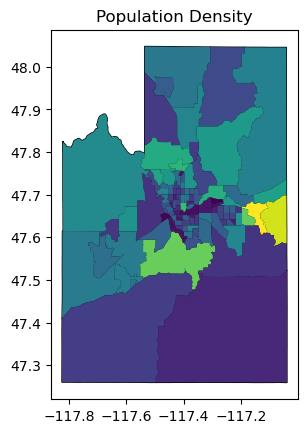

In [21]:
fig,ax = plt.subplots()
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
census_Spokane_gdf.plot(ax=ax, column="TotalPopulation")
plt.title("Population Density")
plt.show()

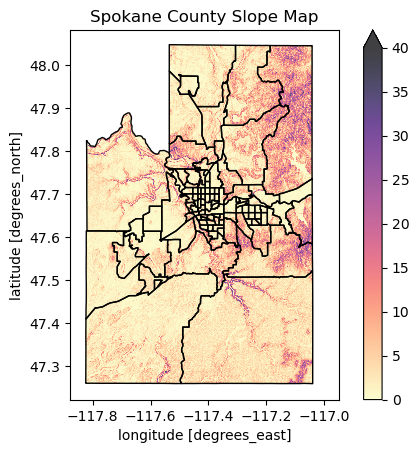

In [38]:
fig,ax = plt.subplots()

slope_Spokane.plot.imshow(ax=ax, alpha=0.75, vmin=0, vmax = 40,cmap="magma_r")
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
plt.title("Spokane County Slope Map")
plt.show()

In [49]:
floodplains_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [46]:
tract_geom_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

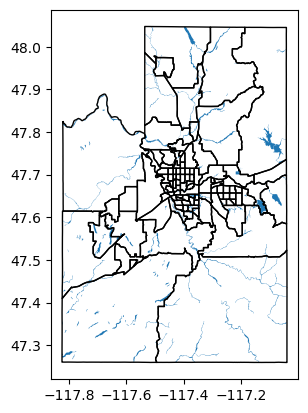

In [57]:
f,ax=plt.subplots()
floodplains_gdf.plot(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

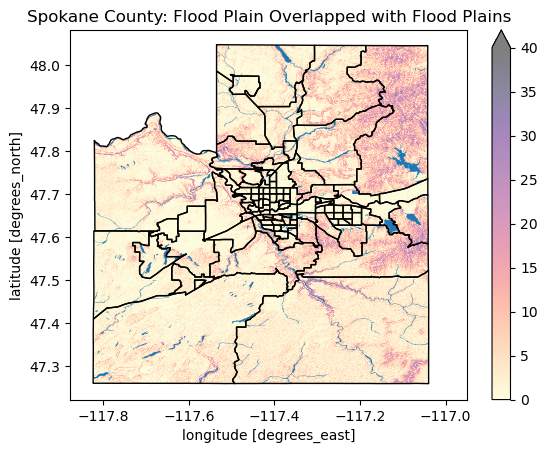

In [56]:


fig,ax = plt.subplots()

floodplains_gdf.plot(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
slope_Spokane.plot.imshow(ax=ax, alpha=0.5, vmin=0, vmax = 40,cmap="magma_r")

plt.title("Spokane County: Flood Plain Overlapped with Flood Plains")
plt.show()

In [68]:
#This Code was aquired using the help of ChatGPT
# URL of the ArcGIS FeatureServer
url = "https://services6.arcgis.com/OO2s4OoyCZkYJ6oE/arcgis/rest/services/Substations/FeatureServer/0/query"

# Define query parameters for the request
params = {
    "where": "COUNTY = 'SPOKANE'",  # Filter for records where the STATE field is 'WA'
    "outFields": "*",  # Fetch all fields
    "f": "geojson"  # Request GeoJSON format
}

# Send the request and get the response
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Load the GeoJSON into a GeoDataFrame
    substation_gdf = gpd.read_file(response.text)

else:
    print(f"Failed to fetch data: {response.status_code}")

Text(0.5, 1.0, 'Substations in Washington (WA)')

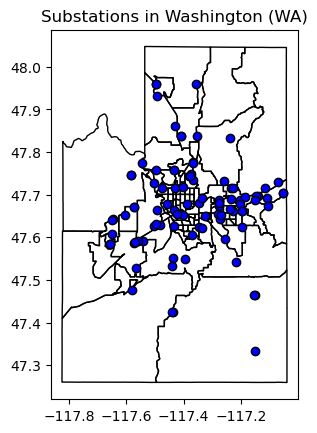

In [69]:
fig,ax = plt.subplots()

tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
substation_gdf.plot(ax=ax, color='blue', edgecolor='black')

plt.title('Substations in Washington (WA)')

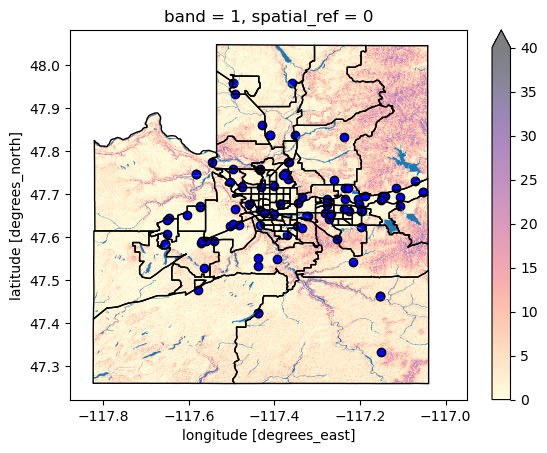

In [70]:
fig,ax = plt.subplots()

substation_gdf.plot(ax=ax, color='blue', edgecolor='black')

floodplains_gdf.plot(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
slope_Spokane.plot.imshow(ax=ax, alpha=0.5, vmin=0, vmax = 40,cmap="magma_r")

In [31]:

# Define the ImageServer exportImage URL
server_url = "https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_MONTHLY_RADIATION_UTC/ImageServer/exportImage"

# Define parameters for exporting an image
params = {
    "bbox": "-125,30,-65,50",  # Bounding box covering the U.S.
    "bboxSR": "4326",
    "imageSR": "4326",
    "size": "1000,1000",  # Resolution of the image
    "format": "tiff",  # Use "png" if you prefer a simple image
    "f": "json",
}

# Request the image
response = requests.get(server_url, params=params)

if response.status_code == 200:
    image_data = response.json()
    image_url = image_data.get("href", None)  # Extract image URL

    if image_url:
        print(f"Downloading image from: {image_url}")

        # Download the raster image
        image_response = requests.get(image_url)
        image_filename = "radiation.tif"

        with open(image_filename, "wb") as file:
            file.write(image_response.content)

        print(f"Image saved as {image_filename}")
    else:
        print("No image URL found in response.")
else:
    print(f"Failed to fetch data: {response.status_code}, Response: {response.text}")


Image saved as radiation.tif
